# Fake News or Real News

---

## Load in our data

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [28]:
true = pd.read_csv('./data/true.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

## Finding distribution of title word counts

In [29]:
true['title_word_count'] = true['title'].map(lambda x: len(x.split(' ')))

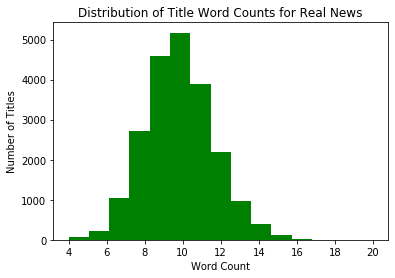

In [30]:
plt.hist(true['title_word_count'], bins = 15, color = 'g')
plt.title('Distribution of Title Word Counts for Real News')
plt.xlabel('Word Count')
plt.ylabel('Number of Titles');

In [6]:
fake = pd.read_csv('./data/fake.csv')
fake.head()

In [7]:
fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [24]:
fake['title_word_count'] = fake['title'].map(lambda x: len(x.split(' ')))

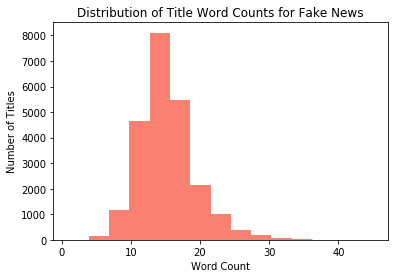

In [27]:
plt.hist(fake['title_word_count'], bins = 15, color = 'salmon')
plt.title('Distribution of Title Word Counts for Fake News')
plt.xlabel('Word Count')
plt.ylabel('Number of Titles');

In [107]:
def most_freq(df):
    cvec = CountVectorizer(stop_words = 'english')
    cvec.fit(df['title'])
    X_train = cvec.transform(df['title'])
    X_train_df = pd.DataFrame(X_train.toarray(),
                              columns=cvec.get_feature_names())
    top_words = {}
    for i in X_train_df.columns:
        top_words[i] =  X_train_df[i].sum()
    return pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True)).head(10)

In [205]:
common_true = most_freq(true)
common_true

,0,1
0,trump,5561
1,says,2981
2,house,1449
3,russia,977
4,north,926
5,korea,898
6,new,875
7,white,818
8,china,782
9,senate,759


In [203]:
common_fake = most_freq(fake)

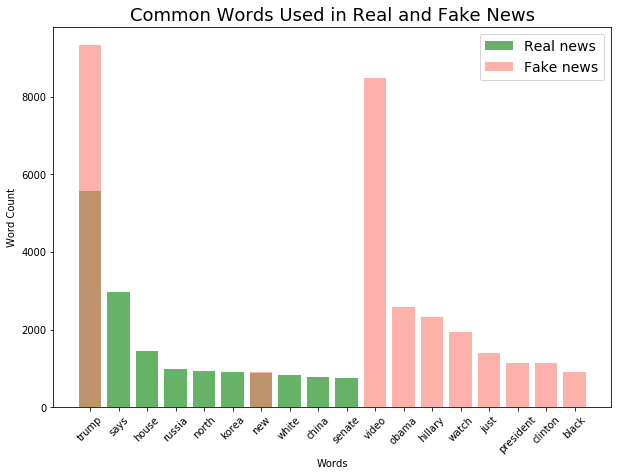

In [220]:
# code inspired by 4.05 classification metrics

plt.figure(figsize = (10, 7))

plt.bar(x = common_true[0],
        height = common_true[1],
        color = 'g',
        alpha = 0.6,
        label = 'Real news')
plt.bar(x = common_fake[0],
        height = common_fake[1],
        color = 'salmon',
        alpha = 0.6,
        label = 'Fake news')

plt.xticks(rotation=45)
plt.ylabel('Word Count')
plt.xlabel('Words')
plt.title('Common Words Used in Real and Fake News', fontsize=18)

plt.legend(fontsize=14);

## Concat the two dataframes

In [93]:
true['category'] = 1

In [94]:
fake['category'] = 0

In [96]:
df = pd.concat([true, fake])

In [97]:
df.shape

(44898, 6)

## Data cleaning

In [98]:
df = df.loc[df['date']!= 'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/',]
df = df.loc[df['date']!= 'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/']
df = df.loc[df['date']!= 'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/']
df = df.loc[df['date']!= 'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg']
df = df.loc[df['date']!= 'https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg']

In [99]:
# Dropped a row with a 'date' url
df.drop([18933], inplace=True)

In [100]:
# Converted 'date' to a datetime pandas format
df['date'] = pd.to_datetime(df['date'])

In [101]:
# Created another column for weekday
df['weekday'] = df['date'].dt.weekday

## Train, test, split

In [103]:
X = df['title']
y = df['category']

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

In [159]:
X_train.shape, y_train.shape

((33665,), (33665,))

In [160]:
X_test.shape, y_test.shape

((11222,), (11222,))

In [161]:
y_test.value_counts(normalize=True)

0    0.522901
1    0.477099
Name: category, dtype: float64

## Model #1

- `PorterStemmer()` and `CountVectorizer()`
- `LogisticRegression()`

`PorterStemmer` code based on [StackOverflow](https://stackoverflow.com/questions/36182502/add-stemming-support-to-countvectorizer-sklearn) question.

In [113]:
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

In [115]:
def porter(text):
    return(stemmer.stem(w) for w in analyzer(text))

In [184]:
pipe = Pipeline([
    ('cvec', CountVectorizer(analyzer=porter, stop_words='english')),
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))
])

In [185]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer=<function porter at 0x7fcc211ffdd0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n

In [186]:
pipe.score(X_train, y_train)

0.984910144066538

In [187]:
pipe.score(X_test, y_test)

0.9659597219746926

## Model #2

- No `PorterStemmer()`

In [124]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [172]:
pipe.fit(X_train, y_train);

In [126]:
pipe.score(X_train, y_train)

0.9840487152829348

In [127]:
pipe.score(X_test, y_test)

0.9529495633576902

## Model #3

Lucas's code

- `TfidfVectorizer()`
- `LogisticRegression()`

In [192]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver = 'liblinear', random_state=42))
])

In [193]:
pipe_params = {
    'tfidf__ngram_range': [(1,2)],
    'tfidf__stop_words': ['english'],    
    'logreg__penalty': [ 'l2'],
    'logreg__C': [ 10],
    'logreg__max_iter' : [ 1000]
    
}

gs = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv=5,
                  scoring = 'accuracy',
                  verbose = 1)

gs.fit(X_train, y_train)

print(f'Best cross validation score: {gs.best_score_}')
print(f'Best parameters to use: {gs.best_params_}')
print(f'Testing score: {gs.score(X_test, y_test)}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished


Best cross validation score: 0.9505124016040398
Best parameters to use: {'logreg__C': 10, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
Testing score: 0.958830867937979


## Model #4

- `PorterStemmer()`
- `TfidfVectorizer()`
- `LogisticRegression()`

In [197]:
stemmer = PorterStemmer()
analyzer = TfidfVectorizer().build_analyzer()

In [198]:
def porter(text):
    return(stemmer.stem(w) for w in analyzer(text))

In [199]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer=porter)),
    ('logreg', LogisticRegression(solver = 'liblinear'))
])

In [201]:
pipe_params = {
    'tfidf__stop_words': ['english', None],
    'tfidf__max_features': [12_000],
    'tfidf__ngram_range': [(1, 2)],
    'logreg__penalty': ['l2'],
    'logreg__C': [15],
    'logreg__max_iter' : [1000]
    
}

gs = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv=5,
                  scoring = 'accuracy',
                  verbose = 1)

gs.fit(X_train, y_train)

print(f'Best cross validation score: {gs.best_score_}')
print(f'Best parameters to use: {gs.best_params_}')
print(f'Testing score: {gs.score(X_test, y_test)}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished


Best cross validation score: 0.9563047675627507
Best parameters to use: {'logreg__C': 15, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'tfidf__max_features': 12000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
Testing score: 0.9642666191409731


## Model #5

- `PorterStemmer()`
- `TfidfVectorizer()`
- `RandomForestClassifier()`

In [222]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer=porter)),
    ('rf', RandomForestClassifier(random_state = 42))
])

In [225]:
params = {
    'rf__n_estimators': [100],
    'rf__max_depth': [None, 1, 2],
    'rf__max_features': ['auto', 'log2']
}

gs = GridSearchCV(pipe,
                  param_grid=params,
                  cv=2,
                  scoring='accuracy',
                  verbose=1)

gs.fit(X_train, y_train)

print(f'Best cross validation score: {gs.best_score_}')
print(f'Best parameters to use: {gs.best_params_}')
print(f'Testing score: {gs.score(X_test, y_test)}')

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.2min finished


Best cross validation score: 0.950423333237898
Best parameters to use: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__n_estimators': 100}
Testing score: 0.9623061842808769


## Results

| Estimators/Classifiers | Model 1 | Model 2 | Model 3 | Model 4 | Model 5 |
|-|:-:|:-:|:-:|:-:|:-:|
| `PorterStemmer()` | X |  |  | X | X |
| `CountVectorizer()` | X | X |  |  |  |
| `TfidfVectorizer()` |  |  | X | X | X |
| `LogisticRegression()` | X | X | X | X |  |
| `RandomForestClassifier()` |  |  |  |  | X |
| Train Score: | 0.9849 | 0.9840 | 0.9505 | 0.9563 | 0.9504 |
| Test Score: | **0.9660** | 0.9529 | 0.9588 | 0.9643 | 0.9623 |

**Hyperparameters used in best score:**

| Estimator/Transformer | Hyperparameter | Set to: |
|-|-|-|
| `CountVectorizer()` | `stop_words` | `english` |
| `LogisticRegression()` | `max_iter` | 1000 |
| `LogisticRegression()` | `solver` | `liblinear` |